In [1]:
import math
import pandas as pd
import numpy as np
import networkx as nx
import csv
import random
import matplotlib.pyplot as plt
import statistics 
from scipy import stats
from scipy.spatial import distance
import io
import time#for recording time 
import sys #for getting size of object
!pip install texttable
from texttable import Texttable

plt.rcParams["figure.figsize"] = (10,10)

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
random.seed(15)

### *Importing files from github for google colab


In [3]:
url = 'https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/contact_rules.csv'
rules_df  = pd.read_csv(url,header=None,engine='python')
url2='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/frequency_contact.csv'
frequency_df= pd.read_csv(url2,header=None,engine='python')
url3='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/varicella_prevalance.csv'
V_prevalence_df =pd.read_csv(url3,header=None,engine='python')
url4='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/population.csv'
population_df=pd.read_csv(url4,header=None,engine='python')

### *importing files from pc


# THE GRAPH CONTROL PANEL

In [4]:
N =1000# Number of nodes
setting='home'#the setting we are evaluating(home,work,school,other)
fit_factor=.75
birth_rate=.03

## 1-Defining Nodes

In [5]:
#defining a dictionary of nodes

group_popularity = dict() #based on consensus year 95
v_prevalence=dict() #based on meta analysis(data is not exact!! update needed!!)contan(age_group,prevalance,lower CL)
nodes_dic=dict() #dictionary of nodes
frequency=dict()


for i, row in population_df.iterrows():
    group_popularity[row[0]]=float(row[1])
    
for i, row in V_prevalence_df.iterrows():
    v_prevalence[row[0]]=[float(row[1]),float(row[2])]
    

#importing data for frequency of contact in each setting for comparison
for i, row in frequency_df.iterrows():
    frequency[row[0]]=dict()
    for i in range(1,6):
        frequency[row[0]][i]=float(row[i])
                    
for i in range(N):#deciding nodes ages
    while True:
        r=random.random()
        t=random.choice(list(group_popularity.keys()))
        if r<=group_popularity[t]:
            nodes_dic[i]={'age':t}
            break


for i in range(N):  #deciding nodes seropositivity
    a=v_prevalence[nodes_dic[i]['age']][0]
    b=v_prevalence[nodes_dic[i]['age']][1]
    r=np.random.random()
    t=np.random.normal(a,(a-b)) 
    if r<=t:
        nodes_dic[i]['infection']=1
    else:
        nodes_dic[i]['infection']=0
        

### Which `group` each node belongs to?

* We  used `Age specific population for Iran` to define probability of each group

In [6]:

# the number of nodes in each group:

age_count = {}
for n in nodes_dic.keys():
    
    if nodes_dic[n]['age'] in age_count:
        age_count[nodes_dic[n]['age']] = age_count[nodes_dic[n]['age']] + 1
    else:
        age_count[nodes_dic[n]['age']] = 1
age_count

{'20_24': 96,
 '5_9': 76,
 '55_59': 43,
 '50_54': 51,
 '30_34': 122,
 '0_4': 88,
 '10_14': 68,
 '25_29': 99,
 '75+': 22,
 '35_39': 86,
 '40_44': 58,
 '15_19': 60,
 '70_74': 16,
 '65_69': 18,
 '45_49': 63,
 '60_64': 34}

## 2-Defining Connection Rules between Node Groups

### `We define rules in terms of connection probability between each two groups`


In [7]:
#importing rules_data from .csv to nested dictionary
rules_data={}  # rules_data contain ->{location:{contactor:{contactee:contact number}
temp_0={}
temp_1={}
location=[]
contactor=[]
contactee=[]
contact_number=[]

for i, row in rules_df.iterrows():
    
    location.append(row[0])
    contactor.append(row[1])
    contactee.append(row[2])
    contact_number.append(float(row[3]))

for o in range (0,1280,256):
    for m in range(o,o+256,16):
        for n in range (m,m+16):
            
            temp_0[contactee[n]]=contact_number[n]
        temp_1[contactor[m]]=temp_0.copy()
    rules_data[location[o]]=temp_1.copy()     

In [8]:
#transformin rules_data to rules so it will be symetrical

rules=dict()

for i in rules_data.keys():
    rules[i]=dict()
    for j in rules_data[i].keys():
        rules[i][j]=dict() 
        for k in rules_data[i][j].keys():

            total_j_k_contact=(rules_data[i][j][k]*age_count[j])+(rules_data[i][k][j]*age_count[k])
            rules[i][j][k]=(total_j_k_contact/2)/age_count[j]

In [9]:
#claculating how many contact a person has with all age groups in the setting
#calculating how many 'connectons' is required for the contacts with specific frequency
rules_sum=dict()
for i in rules.keys():
    rules_sum[i]=dict()
    for j in rules[i].keys():
        t=0
        rules_sum[i][j]={'contact_total':0,'count1':0,'count2':0,'count3':0}
        for k in rules[i][j]:
            t+=rules[i][j][k]
    
        rules_sum[i][j]['contact_total']=t
        rules_sum[i][j]['count1']=t*frequency[i][1]
        rules_sum[i][j]['count2']=t*frequency[i][2]*(7/1.5)
        rules_sum[i][j]['count3']=t*frequency[i][3]*(30/1.5)
        #number of 'contacts' with random probability
        rules_sum[i][j]['count4']=t*(frequency[i][4]+frequency[i][5])
        rules_sum[i][j]['connection_total']=rules_sum[i][j]['count1']+rules_sum[i][j]['count2']+rules_sum[i][j]['count3']
        
        
#a dictionary of weight/upper_weight ratio for each frequency set       
frequency_grouped={1:1,2:(1.5/7),3:(1.5/30),4:0}

table=Texttable()
table.set_deco(Texttable.HEADER)
table.add_rows([['setting','age','contact_total','connection_total','conection 1','conection 2' ,'conection 3','connection 4']])      
print(table.draw())
for i in rules_sum.keys():
    for j in rules_sum[i].keys():
        
        table.add_rows([[i,j,'%f' % rules_sum[i][j]['contact_total'],'%f' % rules_sum[i][j]['connection_total'],'%f' % rules_sum[i][j]['count1'],'%f' % rules_sum[i][j]['count2'],'%f' % rules_sum[i][j]['count3'],'%f' % rules_sum[i][j]['count4']]])
        
        print(table.draw())


setting   age   contact_t   connecti   conectio   conectio   conectio   connecti
                  otal      on_total     n 1        n 2        n 3        on 4  
  all     0_4   10.430289   49.72575   3.980407   12.70241   33.04293   2.075789
                               4                     7          0               
  all     10_   21.755269   103.7168   8.302246   26.49442   68.92022   4.329636
          14                   89                    2          0               
  all     15_   20.112049   95.88293   7.675160   24.49324   63.71453   4.002610
          19                   8                     4          3               
  all     20_   11.349825   54.10958   4.331320   13.82226   35.95599   2.258791
          24                   3                     3          9               
  all     25_   12.104958   57.70963   4.619494   14.74189   38.34824   2.409074
          29                   1                     4          3               
  all     30_   12.234464   

## 3-Defining Rules to Connecting Nodes and Adjusting `Weights`

* This would be the step that our Naive graph would evolve over the time through a simulation process
* we monitor connection between nodes and update weights based on connections

In [10]:
#in this block we've defiend a function "Run" 
def Run(nodes_dic,age_count,frequency_grouped):
    
    #building the array based on nodes_dic
    #graph_array=[N * [[connecetions],[weights],number of the node]
    graph_array=[]
    for i in range(N):
        graph_array.append([[],[],i])
      
    #making a dictionary that consists of lists of nodes in each age group
    nodes_age_grouped=dict() 
    for i in range(N):     
        if nodes_dic[i]['age'] in nodes_age_grouped:
            nodes_age_grouped[nodes_dic[i]['age']].append(i)    
        else:
            nodes_age_grouped[nodes_dic[i]['age']]=[i]
    
    #Copyin age_count to age_available
    age_available=dict()
    for i in age_count.keys():
        age_available[i]=age_count[i]
        
    count1_list=[]
    for i in rules_sum[setting].keys():
            count1_list.append(rules_sum[setting][i]['count1'])
    quartile_count1=np.percentile(count1_list,25)
        
   
    #building list of axial nodes
    print('building list of axial nodes ...')
    axial_nodes={}
    pop_left=N
    while pop_left != 0 :
        
        #this part can be used for adding prefrences to choosing axial nodes
        
        #while True:
            #r=random.random()
            #t=random.choice(list(nodes_age_grouped.keys()))
            #if r <(quartile_count1/rules_sum[setting][t]['count1']):
               # axial=random.choice(nodes_age_grouped[t])
               # break
        axial=random.randint(0,N-1)
        
        if axial not in list(axial_nodes.keys()):
            Age=nodes_dic[axial]['age']
            #the fit_factor helps for reducing houeholdsize
            axial_nodes[axial]=np.random.poisson(lam=(rules_sum[setting][Age]['count1'])*fit_factor)
            pop_left-=(axial_nodes[axial]+1)
            if pop_left < 0:
                axial_nodes[axial]+=pop_left
                pop_left=0
                
                
    #iterating axial nodes
    print('building households ...')
    for contactor in axial_nodes.keys():
        
        
        
        Age=nodes_dic[contactor]['age']
        contact=rules_sum[setting][Age]['contact_total']
        count1=rules_sum[setting][Age]['count1']
        count2=rules_sum[setting][Age]['count2']
        count3=rules_sum[setting][Age]['count3']
        connection=rules_sum[setting][Age]['connection_total']
        list_count={2:count2,3:count3}
        
        
        #age_available is for storing number of nodes without household in each age
        age_available[Age]-=1

        #deciding the size of house hold
        pop_house=axial_nodes[contactor]
        counter=0

        while counter < pop_house :
            
            #in case there is not enough nodes to build the household
            if sum(list(age_available.values()))==0:
                break
            
            r=random.random()
            #deciding the age of connection of the node
            Age_C=random.choice(list(nodes_age_grouped.keys()))
            
            #age_p_pooled is used to get the probability of contact considering all nodes already in family
            age_p_pooled=rules[setting][Age][Age_C]/(len(graph_array[contactor][0])+1)
            for m in graph_array[contactor][0]:
                age_p_pooled+=(rules[setting][nodes_dic[m]['age']][Age_C]/(len(graph_array[contactor][0])+1))
            
            if rules[setting][Age][Age_C]!=0:
                if age_available[Age_C] > 0:
                    if r <= (age_p_pooled)/(contact*age_available[Age_C]):

                        #deciding a random node from the chosen age group to make connection
                        contactee=random.choice(nodes_age_grouped[Age_C])

                        if contactee not in axial_nodes.keys():
                            #if the node doesn't already belong to a family
                            if graph_array[contactee][0]==[] :

                                age_available[Age_C]-=1
                                counter+=1

                                Family=graph_array[contactor][0][:] #list of nodes already in household

                                graph_array[contactor][0].append(contactee)
                                graph_array[contactor][1].append(1)

                                graph_array[contactee][0].append(contactor)
                                graph_array[contactee][1].append(1)

                                #connecting the contactee with other nodes in family

                                for m in range(len(Family)):

                                    graph_array[contactee][0].append(Family[m])
                                    graph_array[contactee][1].append(1)

                                    graph_array[Family[m]][0].append(contactee)
                                    graph_array[Family[m]][1].append(1)
                        
    #building other connections than families
    print('building connections out of household ...')
    
    for contactor in range(N):
        
        Age=nodes_dic[contactor]['age']
        contact=rules_sum[setting][Age]['contact_total']
        count1=rules_sum[setting][Age]['count1']
        count2=rules_sum[setting][Age]['count2']
        count3=rules_sum[setting][Age]['count3']
        connection=rules_sum[setting][Age]['connection_total']
        list_count={2:count2,3:count3}
        #deciding number of connections,(/2) is ecause connections are formed both ways
        k =np.random.poisson(lam=((count2+count3)/2))
        
        counter=0
        while counter<k:

            r=random.random()
            #deciding the age of connection of the node
            t=random.choice(list(nodes_age_grouped.keys()))
            if rules[setting][Age][t]!=0:
                
                min_age_count=min(list(age_count.values()))
                
                if r <= (rules[setting][Age][t])*(min_age_count/age_count[t])/(contact):

                    #deciding the weight of connection of the node
                    r2=random.random()
                    t2=random.randint(2,3)
                    if r2 <= list_count[t2]/(count2+count3) :

                        #deciding a random node from the chosen age group to make connection
                        contactee=random.choice(nodes_age_grouped[t])

                        if contactee not in graph_array[contactor ][0]:
                            if contactee != contactor:

                                graph_array[contactor ][0].append(contactee)
                                graph_array[contactor ][1].append(t2)

                                graph_array[contactee][0].append(contactor )
                                graph_array[contactee][1].append(t2)

                        counter+=1
                            
                            
#putting data from graph to a list of connections
    connections_list=list()
    for i in range(N):
        for j in range(len(graph_array[i][0])):
            k=graph_array[i][0][j]
            l=graph_array[i][1][j]
            if i<k:
                connections_list.append((i,k,l))
            elif k<i:
                connections_list.append((k,i,l))
    #removing duplicates
    connections_list=list(set(connections_list))
    
                             
    results={'graph_array':graph_array,'nodes_age_grouped':nodes_age_grouped,'connections':connections_list}                           
    return(results)


In [11]:
#this defines a function for aging the graph
def G_age(nodes_dict,graph_dict):
    return()
    

In [12]:
#Run_S runs the model and stores conections but do not change the weights
def Run_S (nodes_dic,N_day,rules,age_count,N,results):
    
    nodes_age_grouped=results['nodes_age_grouped']
    graph_array=results['graph_array']
    connections=results['connections']

    #in this list the day that connection has happened is stored
    #contacts=[N*[D0[],D1[]]]
    contacts=[] 
    for i in range(N):
        contacts.append([])
        
            
    for d in range(N_day):
        #adding empty list for day to each node
        for i in range(N):
            contacts[i].append([])
         #checking if contacts happen and storing them   
        for j in connections:
                r=random.random()
                if frequency_grouped[j[2]]>=r:
                    contacts[j[0]][d].append(j[1])
                    contacts[j[1]][d].append(j[0])
             
            #checking for random contacts between i and other nodes 
            #number of random contacts
        for i in range(N):
            count_random=rules_sum[setting][nodes_dic[i]['age']]['count4']
            for k in range(np.random.poisson(lam=count_random)):

                while True:
                    r=random.random()
                    #deciding the age of connection of the node
                    t=random.choice(list(nodes_age_grouped.keys()))
                    age_p=rules[setting][nodes_dic[i]['age']][t]
                    if age_p!=0:
                        if r <= age_p/rules_sum[setting][nodes_dic[i]['age']]['contact_total'] :
                            #deciding a random node from the chosen age group to make connection
                            t2=random.choice(nodes_age_grouped[t])
                            #making sure t2 and i had no connection and no contact before
                            if (t2 not in graph_array[i][0]) and (t2 not in contacts[i][d]):
                                contacts[i][d].append(t2)
                                break
                            
        
    
    return(contacts)

# 4- Monitroing the graph
### we monitor the graph for age specific number of contact per day and frequeny of contact

In [13]:
#this function returns measures for comparison age stratified number of contacts 


def Metric_W(Run_S,age_count,rules) : 
    

    contacts=Run_S
    
    
    L1=[]
    L2=[]
    L3=[]
    

    rules_m=dict()
    rules_m[setting]=dict()

    for i in rules[setting].keys():
        rules_m[setting][i]=dict()
        for j in rules[setting][i].keys():
             rules_m[setting][i][j]=0
    
    for i in range(N):
            for j in contacts[i][0]:
                age_p=rules[setting][nodes_dic[i]['age']][nodes_dic[j]['age']]
                if i!=j and age_p!=0 : 
                    t= 1/age_count[nodes_dic[i]['age']]
                    rules_m[setting][nodes_dic[i]['age']][nodes_dic[j]['age']]+=t
                         
    for i in rules_m[setting].keys():
        for j in rules_m[setting][i].keys():
            
            L1.append(rules[setting][i][j])
            L2.append(rules_m[setting][i][j])
            if rules[setting][i][j]!=0:
                L3.append(abs((rules_m[setting][i][j])-(rules[setting][i][j]))/rules[setting][i][j])
            else:
                L3.append(0)
                
    wilx=stats.wilcoxon(L1,L2,zero_method='wilcox', correction=False, alternative='two-sided')
    M_Abs=statistics.mean(L3)
    #Manhattan distance
    man_dis=distance.cityblock(L1, L2)
    #Euclidean distance
    eu_dis=distance.euclidean(L1,L2)
    #Chebyshev distance
    cheb_dis=distance.chebyshev(L1,L2)
    #Pearson corelation
    prs_cor=stats.pearsonr(L1,L2)
    
    
    Metric_W ={'wilx':wilx,'M_Abs':M_Abs,'rules_m':rules_m,'L3':L3,'man_dis':man_dis,'eu_dis':eu_dis,'cheb_dis':cheb_dis, 'prs_cor': prs_cor}
    
    return(Metric_W)

In [14]:
#defining a function that returns mean absoloute error 'frequency of contacts ' in the last x day of model
def metric_F(Run_S,results,age_count):
    
    contacts=Run_S
    n=0
    graph_array=results['graph_array']
    
    L1=[]
    L2=[]
    
    frequency_m=dict()
    for i in frequency.keys():
        frequency_m[i]={1:0,2:0,3:0,4:0}

    for i in range(N):
        #contacts at day zero
        for j in contacts[i][0]:
            #for nodes with contact and connection
            if j in graph_array[i][0]:  
            #finding the weight of i*j
                position=0
                for k in graph_array[i][0]:
                    if k==j:
                        t=graph_array[i][1][position]
                        
                    position+=1

            #for nodes with contact but not connection(random nodes)        
            elif j not in graph_array[i][0]:
                t=0
                
            n+=1

            if t==0  :
                frequency_m[setting][4]+=1


            elif t==1:
                frequency_m[setting][1]+=1


            elif t==2:
                frequency_m[setting][2]+=1


            elif  t==3:

                frequency_m[setting][3]+=1



                        
                    
    for i in frequency_m[setting].keys():
        if n!=0:
        
            frequency_m[setting][i]=frequency_m[setting][i]/n
        if n==0:
            
            frequency_m[setting][i]=0
    
    
    return(frequency_m)

In [15]:
start = time.time()

# evaluating results
### this part of code evaluates results of  function Run for the inputs

###### Run -> input : increase_ratio,D,nodes_dic
###### Run -> output : contacted_all, G, weight_all, group_count


In [16]:
#this part runs the model
results=Run(nodes_dic,age_count,frequency_grouped)


building list of axial nodes ...
building households ...
building connections out of household ...


In [17]:
end=time.time()

In [18]:
#running a 1 day simulation of model
contacts=Run_S(nodes_dic,1,rules,age_count,N,results)

In [19]:
#this part returns the measures for age stratified number of contact
Metr_W=Metric_W(contacts,age_count,rules)



In [20]:
#this part shows number of age stratified contact from data and model for comparision
t=0
L3=Metr_W['L3']
table=Texttable()
table.set_deco(Texttable.HEADER)
table.add_rows([['age i','age j','rules_m  ',' rules  ','Abs_error']])

print(table.draw())

for i in rules[setting].keys():
    
    for j in rules[setting][i].keys():
        
        model=Metr_W["rules_m"][setting][i][j]
        data=rules[setting][i][j]
        table.add_rows([[i,j,'%f' %  model,'%f' % data,'%f' % L3[t]]])
        print(table.draw())
        t+=1

        

age i   age j    rules_m      rules    Abs_error
 0_4     0_4    0.625000    0.439130   0.423269 
 0_4     5_9    0.511364    0.535432   0.044951 
 0_4    10_14   0.250000    0.339040   0.262625 
 0_4    15_19   0.170455    0.181596   0.061351 
 0_4    20_24   0.250000    0.357210   0.300132 
 0_4    25_29   0.386364    0.652748   0.408097 
 0_4    30_34   0.727273    0.852899   0.147293 
 0_4    35_39   0.500000    0.649060   0.229655 
 0_4    40_44   0.238636    0.299186   0.202381 
 0_4    45_49   0.170455    0.168363   0.012425 
 0_4    50_54   0.193182    0.217748   0.112821 
 0_4    55_59   0.193182    0.240038   0.195204 
 0_4    60_64   0.261364    0.217282   0.202877 
 0_4    65_69   0.181818    0.078233   1.324058 
 0_4    70_74   0.045455    0.029562   0.537586 
 0_4     75+    0.068182    0.028746   1.371851 
10_14    0_4    0.338235    0.438758   0.229108 
10_14    5_9    0.426471    0.607497   0.297988 
10_14   10_14   0.441176    0.794020   0.444376 
10_14   15_19   0.35

graph of data


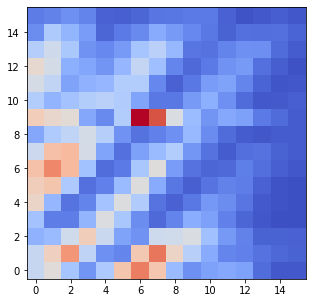

graph of model


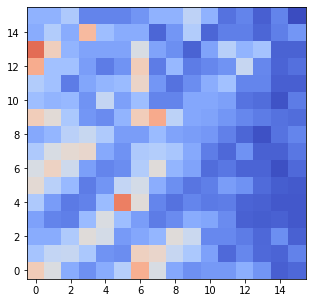

In [21]:
#heat map

plt.rcParams["figure.figsize"] = (5,5)

color_graph=[]

V_max=0 

for i in rules[setting].keys():
    color_graph.append([])
    for j in rules[setting][i]:
        color_graph[-1].append(rules[setting][i][j])
        if V_max<rules[setting][i][j]:
            V_max=rules[setting][i][j]
    
print('graph of data')       
plt.pcolor(range(0,16,1),range(0,16,1),color_graph,shading='auto', cmap='coolwarm',vmin=0,vmax=V_max)
plt.show()

color_graph_m=[]

for i in Metr_W["rules_m"][setting].keys():
    color_graph_m.append([])
    for j in Metr_W["rules_m"][setting][i]:
        color_graph_m[-1].append(Metr_W["rules_m"][setting][i][j])
        if V_max<Metr_W["rules_m"][setting][i][j]:
            V_max=Metr_W["rules_m"][setting][i][j]
    

print('graph of model')          
plt.pcolor(range(0,16,1),range(0,16,1),color_graph_m,shading='auto', cmap='coolwarm',vmin=0,vmax=V_max)
plt.show()

In [22]:
#this part returns p_value wilcoxon for comparison age stratified number of contacts 

print('p-value wilcoxon :','%f' % Metr_W['wilx'][1])

print('Pearson Corealtion :',Metr_W['prs_cor'][0],'%f' % Metr_W['prs_cor'][1])

print('mean absoloute error : ', Metr_W['M_Abs'])

print('Manhattan distance :',Metr_W['man_dis'])

print('Euclidean distance :',Metr_W['eu_dis'])

print('Chebyshev distance :',Metr_W['cheb_dis'])

p-value wilcoxon : 0.102742
Pearson Corealtion : 0.8240171730445425 0.000000
mean absoloute error :  0.5838356674186593
Manhattan distance : 20.450355135829337
Euclidean distance : 1.815900037723432
Chebyshev distance : 0.5064161111111114


red -> model blue->data
home : 1 // 0.711271 // 0.703030
home : 2 // 0.142048 // 0.154703
home : 3 // 0.092640 // 0.091225
home : 4 // 0.054040 // 0.051042


(0.0, 5.0, 0.0, 1.0)

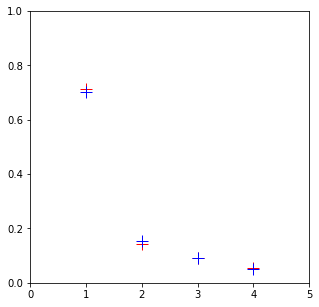

In [23]:
#this shows the fitting for frequency

results_F=metric_F(contacts,results,age_count)

plt.rcParams["figure.figsize"] = (5,5)

print('red -> model blue->data')

for i in results_F[setting].keys():
    L=list(frequency[setting].values())
    L[3]+=L[4]
    
    print (setting,':',i,'//','%f' % results_F[setting][i],'//','%f' % L[i-1])
    plt.plot(i,results_F[setting][i],'+r',linewidth=1, markersize=12,alpha=1)
    plt.plot(i,L[i-1],'+b',linewidth=1, markersize=12,alpha=1)
    
plt.axis([0,5,0,1])

In [24]:
print(end-start)

5.862831354141235


plt.rcParams["figure.figsize"] = (10,10)

for i in range(N):
    plt.plot(i,results['graph_array'][i][1].count(1),'r.',linewidth=.5, markersize=2,alpha=.5)
#plt.axis([4285,4290,50,70])
plt.show()   
for i in range(N):
    plt.plot(i,results['graph_array'][i][1].count(2),'b.',linewidth=.5, markersize=2,alpha=.5)
plt.show()
for i in range(N):
    plt.plot(i,results['graph_array'][i][1].count(3),'g.',linewidth=.5, markersize=2,alpha=.5)
    

In [34]:

table=Texttable()
table.set_deco(Texttable.HEADER)
table.add_rows([['frequency group','     data    ','     model    ']])
print(table.draw())

list_contacts={'data':{1:0,2:0,3:0,4:0,'tot':0},'model':{1:0,2:0,3:0,4:0,'tot':0}}
#based on rules_sum
for i in rules_sum[setting].keys():
    list_contacts['data'][1]+=rules_sum[setting][i]['count1']*age_count[i]
    list_contacts['data'][2]+=(rules_sum[setting][i]['count2']*(1.5/7))*age_count[i]
    list_contacts['data'][3]+=(rules_sum[setting][i]['count3']*(1.5/30))*age_count[i]
    list_contacts['data'][4]+=rules_sum[setting][i]['count4']*age_count[i]
    list_contacts['data']['tot']+=rules_sum[setting][i]['contact_total']*age_count[i]
    
#based on contacts
for i in contacts:
    list_contacts['model']['tot']+=len(i[0])
for i in results_F[setting].keys():
    list_contacts['model'][i]=(results_F[setting][i]*list_contacts['model']['tot'])

for i in list_contacts['data'].keys():
    
    table.add_rows([[i,'%f' %list_contacts['data'][i],'%f' %list_contacts['model'][i]]])
    print(table.draw())


        

frequency group          data            model  
       1           2803.729895     2764.000000  
       2           616.964918       552.000000  
       3           363.813146       360.000000  
       4           203.557711       210.000000  
      tot          3988.065670     3886.000000  


 age    house hold size data   house hold size model   population
 0_4          3.716409               3.340909            0.088   
10_14         4.064060               3.117647            0.068   
15_19         3.340160               2.900000             0.06   
20_24         1.960181               2.135417            0.096   
25_29         2.177942               2.545455            0.099   
30_34         2.454037               2.836066            0.122   
35_39         3.014318               2.895349            0.086   
40_44         2.875019               3.086207            0.058   
45_49         2.201329               2.555556            0.063   
 5_9          4.329986               3.171053            0.076   
50_54         2.377441               2.431373            0.051   
55_59         2.406336               2.372093            0.043   
60_64         2.530451               2.558824            0.034   
65_69         2.486699               2.888889            0.018   
70_74     

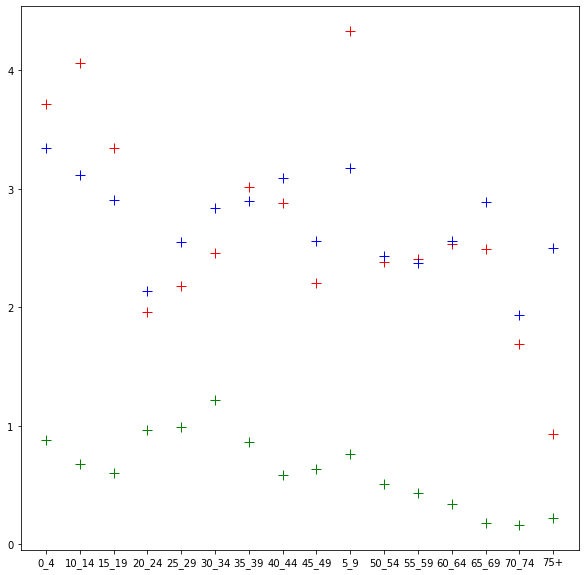

In [35]:
table=Texttable()
table.set_deco(Texttable.HEADER)
table.add_rows([[' age ','house hold size data','house hold size model','population']])
print(table.draw())
plt.rcParams["figure.figsize"] = (10,10)

house_hold_size={}
for i in age_count.keys():
    house_hold_size[i]=0
for i in results['graph_array']:
    Age=nodes_dic[i[2]]['age']
    house_hold_size[Age]+=(i[1].count(1)/age_count[Age])

for i in rules_sum[setting].keys():
    table.add_rows([[i,'%f' %rules_sum[setting][i]['count1'],'%f' %house_hold_size[i],age_count[i]/N]])
    print(table.draw())
    plt.plot(i,rules_sum[setting][i]['count1'],'r+',linewidth=2, markersize=10,alpha=1)
    plt.plot(i,house_hold_size[i],'b+',linewidth=2, markersize=10,alpha=1)
    plt.plot(i,age_count[i]/(N/10),'g+',linewidth=2, markersize=10,alpha=1)